In [477]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
# 한글 폰트 문제 해결 
# matplotlib은 한글 폰트를 지원하지 않음
# os정보
import platform

# font_manager : 폰트 관리 모듈
# rc : 폰트 변경 모듈
from matplotlib import font_manager, rc
# unicode 설정
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic') # os가 macos
elif platform.system() == 'Windows':
    path = 'c:/Windows/Fonts/malgun.ttf' # os가 windows
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print("Unknown System")

In [478]:
df2 = pd.read_csv("../../Data/03.통합.csv")
sido_df = df2.iloc[:, :2]
sido_df

,년도,시도
0,2013,경기도
1,2013,서울특별시
2,2013,경상남도
3,2013,부산광역시
4,2013,대구광역시
...,...,...
131,2020,충청북도
132,2020,대전광역시
133,2020,강원도
134,2020,제주특별자치도


In [479]:
df = pd.read_csv("../../Data/companies/통합_k.csv")
df = df[['전출인구',	'출생아수',	'산부인과의원수',	'초등학생인원수',	'도매 및 소매업 신생', 'cluster_id']]

In [480]:
from sklearn.cluster import KMeans

df_temp = df.copy()
# df_temp.set_index('시도', inplace=True)
df_km = df_temp

data_points = df_km.values
km = KMeans(n_clusters=4).fit(data_points) # n_clusters 에 값을 정해주기!
df_km['cluster_id'] = km.labels_

df_km['cluster_id'] = df_km['cluster_id'] + 10
df_km_temp = df_km.sort_values(by='전출인구', ascending=True)
temp_list = df_km_temp['cluster_id'].unique()

# 클러스터 0~1로 변경
i = 3
for temp in temp_list:
    df_km['cluster_id'][df_km['cluster_id'] == temp] = i
    i-=1
df_km['cluster_id'] = np.round(df_km['cluster_id'] / 3, 2)
df_km['cluster_id'].unique()

# Feature, Target
data = df_km[['전출인구', '출생아수', '산부인과의원수', '초등학생인원수', '도매 및 소매업 신생']].to_numpy()
target = df_km['cluster_id'].to_numpy()

# 데이터셋 나누기 
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = \
    train_test_split(data, target, test_size=0.2) # random_state=42,  stratify=target
    
# 회귀 예측
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(train_input, train_target)
print("Train score:", lr.score(test_input, test_target))

Train score: 0.8755318069993947


In [481]:
pred_cluster = []

for i in range(len(df_km)):
    pred_cluster.append(lr.predict([[df.iloc[i,0], df.iloc[i,1], df.iloc[i,2], df.iloc[i,3], df.iloc[i,4]]]))

df_km['pred_cluster'] = pred_cluster
df_km = pd.concat([sido_df, df_km], axis=1)
df_km

,년도,시도,전출인구,출생아수,산부인과의원수,초등학생인원수,도매 및 소매업 신생,cluster_id,pred_cluster
0,2013,경기도,1821303,112129,286,739619,49143,0.00,[-0.03978049936027772]
1,2013,서울특별시,1620640,84066,395,469392,48097,0.33,[0.2437447815851952]
2,2013,경상남도,423864,29504,65,190166,12612,0.67,[0.7638839855191077]
3,2013,부산광역시,496161,25831,82,160821,13902,0.67,[0.7792067914117373]
4,2013,대구광역시,363224,19340,86,136309,9981,0.67,[0.8483379857659793]
...,...,...,...,...,...,...,...,...,...
131,2020,충청북도,226441,8607,40,85135,6103,1.00,[0.9247461665770794]
132,2020,대전광역시,243418,7481,44,79807,6405,1.00,[0.9280282246592213]
133,2020,강원도,217897,7835,32,73478,5554,1.00,[0.9348751507283882]
134,2020,제주특별자치도,94736,3989,23,40575,2856,1.00,[0.9893741478308293]


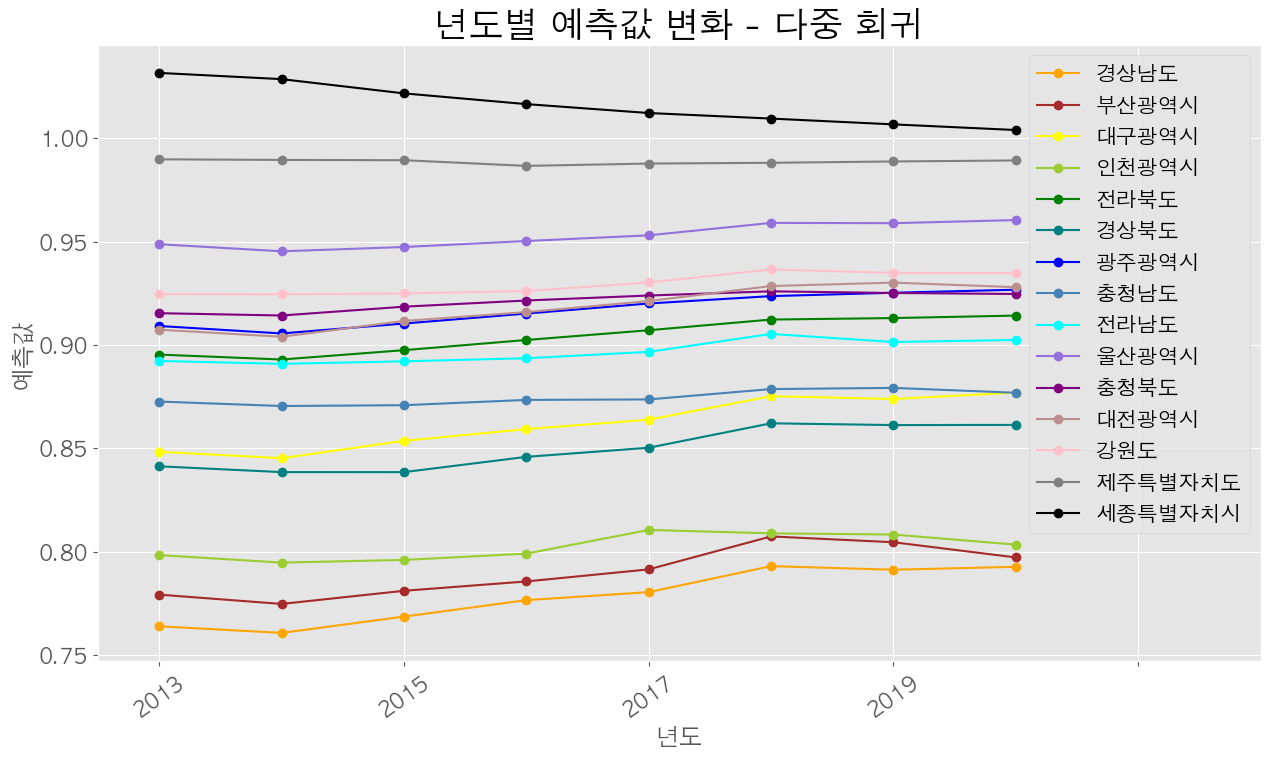

In [482]:
plt.style.use('ggplot')

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1,1,1) #하나짜리 그래프

sido = pd.unique(df_km.시도)
years = list(range(8))
colors = ['red', 'salmon', 'orange', 'brown', 'yellow', 'yellowgreen', 'green', 'teal', 'blue', 'steelblue', 'cyan', 'mediumpurple', 'purple', 'rosybrown', 'pink', 'gray','black']

for i in [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]:
    
    ax.plot(
        years,
        df_km[df_km['시도'] == sido[i]]['pred_cluster'],
        marker='o',
        label=sido[i],
        color=colors[i]
    )

ax.legend(loc='best', fontsize=15)
ax.set_xlim(-0.5, 9)
# ax.set_ylim(0.75, 1.05)
plt.yticks(fontsize=15)
ax.set_title('년도별 예측값 변화 - 다중 회귀', size=25)
ax.set_ylabel('예측값', fontsize=17)
ax.set_xlabel('년도', fontsize=17)
ax.set_xticklabels([0, 2013, 2015, 2017, 2019], rotation=35, fontsize=15)
# ax.set_yticklabels([0.75, 0.80, 0.85, 0.9, 0.95, 1.00, 1.05], fontsize=15)

plt.show()

In [483]:
df_km[df_km['시도'] == '강원도']

,년도,시도,전출인구,출생아수,산부인과의원수,초등학생인원수,도매 및 소매업 신생,cluster_id,pred_cluster
14,2013,강원도,214931,10980,34,83187,5355,1.0,[0.9246477902840585]
31,2014,강원도,226284,10662,32,80458,5432,1.0,[0.9245861118617531]
48,2015,강원도,222352,10929,33,78414,5570,1.0,[0.9250079307517967]
65,2016,강원도,221592,10058,29,76772,5631,1.0,[0.9261388878572138]
82,2017,강원도,209618,8958,30,75722,5690,1.0,[0.9303176574245469]
99,2018,강원도,220252,8351,31,75412,4866,1.0,[0.9366022336247876]
116,2019,강원도,215965,8283,32,75617,5238,1.0,[0.9349403190934454]
133,2020,강원도,217897,7835,32,73478,5554,1.0,[0.9348751507283882]


In [484]:
lr.predict([[214931, 20980, 40, 183187, 10055]])

array([0.81561402])

## 만약 강원도의 기업 수를 경기도에 맞춘다면?

In [485]:
gang = df_km[df_km['시도'] == '강원도']
gang.reset_index(drop=True, inplace=True)
gang['도매 및 소매업 신생']

0    5355
1    5432
2    5570
3    5631
4    5690
5    4866
6    5238
7    5554
Name: 도매 및 소매업 신생, dtype: int64

In [486]:
gyeong = df_km[df_km['시도'] == '경기도']
gyeong.reset_index(drop=True, inplace=True)
gyeong['도매 및 소매업 신생']

0    49143
1    51661
2    49285
3    52487
4    52606
5    49364
6    52700
7    63145
Name: 도매 및 소매업 신생, dtype: int64

In [487]:
# 강원도 기업 수를 경기도 기업 수로 바꾸기
gang['도매 및 소매업 신생'] = gyeong['도매 및 소매업 신생']
gang

,년도,시도,전출인구,출생아수,산부인과의원수,초등학생인원수,도매 및 소매업 신생,cluster_id,pred_cluster
0,2013,강원도,214931,10980,34,83187,49143,1.0,[0.9246477902840585]
1,2014,강원도,226284,10662,32,80458,51661,1.0,[0.9245861118617531]
2,2015,강원도,222352,10929,33,78414,49285,1.0,[0.9250079307517967]
3,2016,강원도,221592,10058,29,76772,52487,1.0,[0.9261388878572138]
4,2017,강원도,209618,8958,30,75722,52606,1.0,[0.9303176574245469]
5,2018,강원도,220252,8351,31,75412,49364,1.0,[0.9366022336247876]
6,2019,강원도,215965,8283,32,75617,52700,1.0,[0.9349403190934454]
7,2020,강원도,217897,7835,32,73478,63145,1.0,[0.9348751507283882]


In [488]:
# 바꾼 값으로 예측값 다시 만들기
pred_cluster = []

for i in range(len(gang)):
    pred_cluster.append(lr.predict([[gang.iloc[i,2], gang.iloc[i,3], gang.iloc[i,4], gang.iloc[i,5], gang.iloc[i,6]]]))

gang['pred_cluster'] = pred_cluster
# gang = pd.concat([sido_df, df_km], axis=1)
gang

,년도,시도,전출인구,출생아수,산부인과의원수,초등학생인원수,도매 및 소매업 신생,cluster_id,pred_cluster
0,2013,강원도,214931,10980,34,83187,49143,1.0,[0.6338504083105427]
1,2014,강원도,226284,10662,32,80458,51661,1.0,[0.61757797786948]
2,2015,강원도,222352,10929,33,78414,49285,1.0,[0.6346953439021521]
3,2016,강원도,221592,10058,29,76772,52487,1.0,[0.6149668286229246]
4,2017,강원도,209618,8958,30,75722,52606,1.0,[0.6187471364446102]
5,2018,강원도,220252,8351,31,75412,49364,1.0,[0.6410897209944435]
6,2019,강원도,215965,8283,32,75617,52700,1.0,[0.6197437962281169]
7,2020,강원도,217897,7835,32,73478,63145,1.0,[0.5524116441686746]


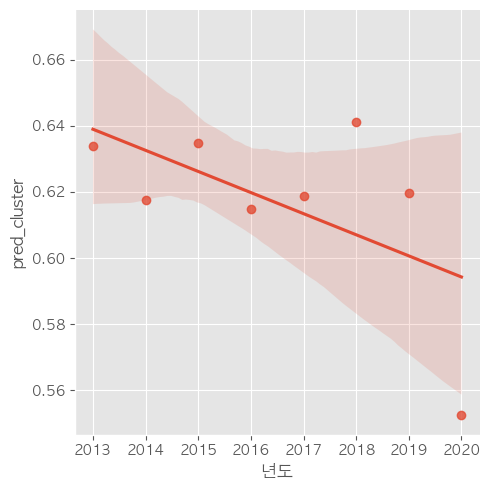

In [489]:
# 회귀선 그려보깅!!
bb = gang.astype({'년도':float, 'pred_cluster':float})
sns.lmplot(x='년도', y='pred_cluster', data=bb)

- 지역별 데이터를 교체해서 보여줄 수는 있다.

In [490]:
# Feature, Target
data = gang[['년도']].to_numpy()
target = gang['pred_cluster'].to_numpy()

# 회귀 예측
from sklearn.linear_model import LinearRegression
lr2 = LinearRegression()
lr2.fit(data, target)
print(lr2.coef_, lr2.intercept_)

[-0.00638427] 13.49051912732163


In [491]:
gang

,년도,시도,전출인구,출생아수,산부인과의원수,초등학생인원수,도매 및 소매업 신생,cluster_id,pred_cluster
0,2013,강원도,214931,10980,34,83187,49143,1.0,[0.6338504083105427]
1,2014,강원도,226284,10662,32,80458,51661,1.0,[0.61757797786948]
2,2015,강원도,222352,10929,33,78414,49285,1.0,[0.6346953439021521]
3,2016,강원도,221592,10058,29,76772,52487,1.0,[0.6149668286229246]
4,2017,강원도,209618,8958,30,75722,52606,1.0,[0.6187471364446102]
5,2018,강원도,220252,8351,31,75412,49364,1.0,[0.6410897209944435]
6,2019,강원도,215965,8283,32,75617,52700,1.0,[0.6197437962281169]
7,2020,강원도,217897,7835,32,73478,63145,1.0,[0.5524116441686746]


## 강원도의 데이터를 50% 올려 예측

In [492]:
# 강원도 데이터 중 전출인구만 50% 늘리기
gang['전출인구'] = gang['전출인구'] * 1.5
gang

,년도,시도,전출인구,출생아수,산부인과의원수,초등학생인원수,도매 및 소매업 신생,cluster_id,pred_cluster
0,2013,강원도,322396.5,10980,34,83187,49143,1.0,[0.6338504083105427]
1,2014,강원도,339426.0,10662,32,80458,51661,1.0,[0.61757797786948]
2,2015,강원도,333528.0,10929,33,78414,49285,1.0,[0.6346953439021521]
3,2016,강원도,332388.0,10058,29,76772,52487,1.0,[0.6149668286229246]
4,2017,강원도,314427.0,8958,30,75722,52606,1.0,[0.6187471364446102]
5,2018,강원도,330378.0,8351,31,75412,49364,1.0,[0.6410897209944435]
6,2019,강원도,323947.5,8283,32,75617,52700,1.0,[0.6197437962281169]
7,2020,강원도,326845.5,7835,32,73478,63145,1.0,[0.5524116441686746]


In [493]:
# 바꾼 값으로 예측값 다시 만들기
pred_cluster = []

for i in range(len(gang)):
    pred_cluster.append(lr.predict([[gang.iloc[i,2], gang.iloc[i,3], gang.iloc[i,4], gang.iloc[i,5], gang.iloc[i,6]]]))

gang['pred_cluster'] = pred_cluster
gang

,년도,시도,전출인구,출생아수,산부인과의원수,초등학생인원수,도매 및 소매업 신생,cluster_id,pred_cluster
0,2013,강원도,322396.5,10980,34,83187,49143,1.0,[0.6231826971288661]
1,2014,강원도,339426.0,10662,32,80458,51661,1.0,[0.6063467810805825]
2,2015,강원도,333528.0,10929,33,78414,49285,1.0,[0.623659304816733]
3,2016,강원도,332388.0,10058,29,76772,52487,1.0,[0.6039685107619828]
4,2017,강원도,314427.0,8958,30,75722,52606,1.0,[0.6083431264019421]
5,2018,강원도,330378.0,8351,31,75412,49364,1.0,[0.6301579116082374]
6,2019,강원도,323947.5,8283,32,75617,52700,1.0,[0.6090247643278754]
7,2020,강원도,326845.5,7835,32,73478,63145,1.0,[0.5415967209451572]


In [494]:
# Feature, Target
data = gang[['년도']].to_numpy()
target = gang['pred_cluster'].to_numpy()

# 회귀 예측
from sklearn.linear_model import LinearRegression
lr2 = LinearRegression()
lr2.fit(data, target)
print(lr2.coef_, lr2.intercept_)

[-0.00635526] 13.421158149837822
